In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange
from utils.create_data import *
from utils.data import *
from utils.metrics import plot_tsne
from utils.network_lstm import LSTMGenerator, LSTMDiscriminator, gen_model_rnn

Modèle très semblable à ``gan_simulation.ipynb`` mais l'architecture du generator et discriminator sont des lstm. 
# TODO: Developper le modèle (entrainer plus, voir si amélioration) je ne l'ai pas terminé

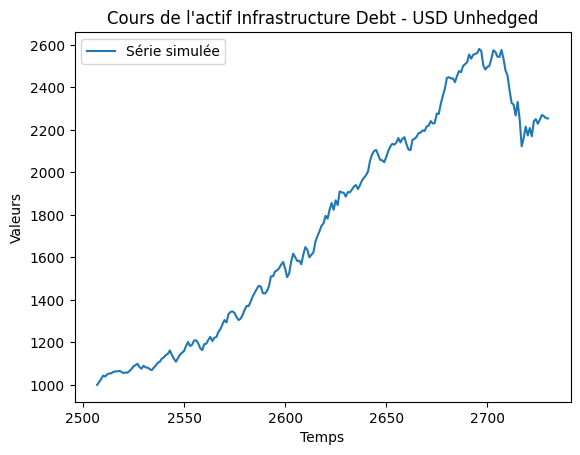

In [4]:
df = pd.read_csv('./data/GANData.csv')
actif = "Infrastructure Debt - USD Unhedged"
simple_plot(df[df['ASSETNAME']==actif]['PRICE'], f"Cours de l'actif {actif}")

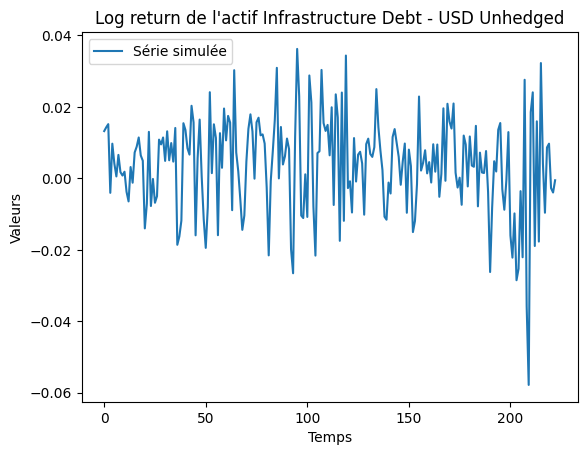

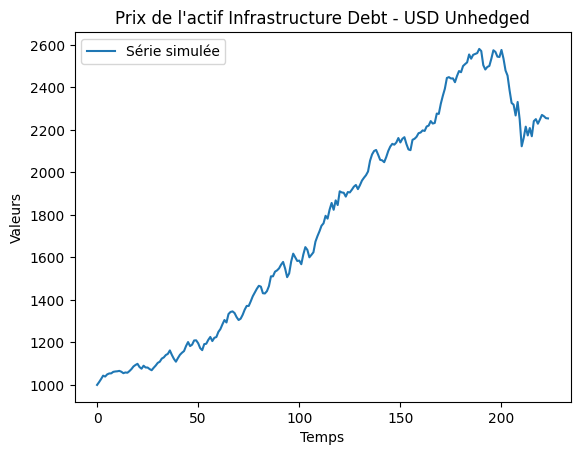

In [5]:
sdf = df[df['ASSETNAME']==actif]['PRICE']
y = np.log(sdf/sdf.shift(1))[1:].to_numpy()
true_y = df[df['ASSETNAME']==actif]['PRICE'].to_numpy()
simple_plot(y[:], f"Log return de l'actif {actif}")
simple_plot(true_y[:], f"Prix de l'actif {actif}")

In [26]:
latent_dim = 20 # Dimension du "bruit" d'entrée
ts_dim = 50 # Dimension de sortie
conditional = 10 # Dimension de la partie "commune"

generator = LSTMGenerator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)
discriminator = LSTMDiscriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 200
batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = 'test'
print(use_cuda)

train = gen_model_rnn(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda)
train.train_model(epochs=epochs)

True


  0%|          | 0/200 [00:00<?, ?it/s]

/home/onyxia/work/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1283: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
100%|██████████| 200/200 [00:47<00:00,  4.25it/s]


<Figure size 1000x1000 with 0 Axes>

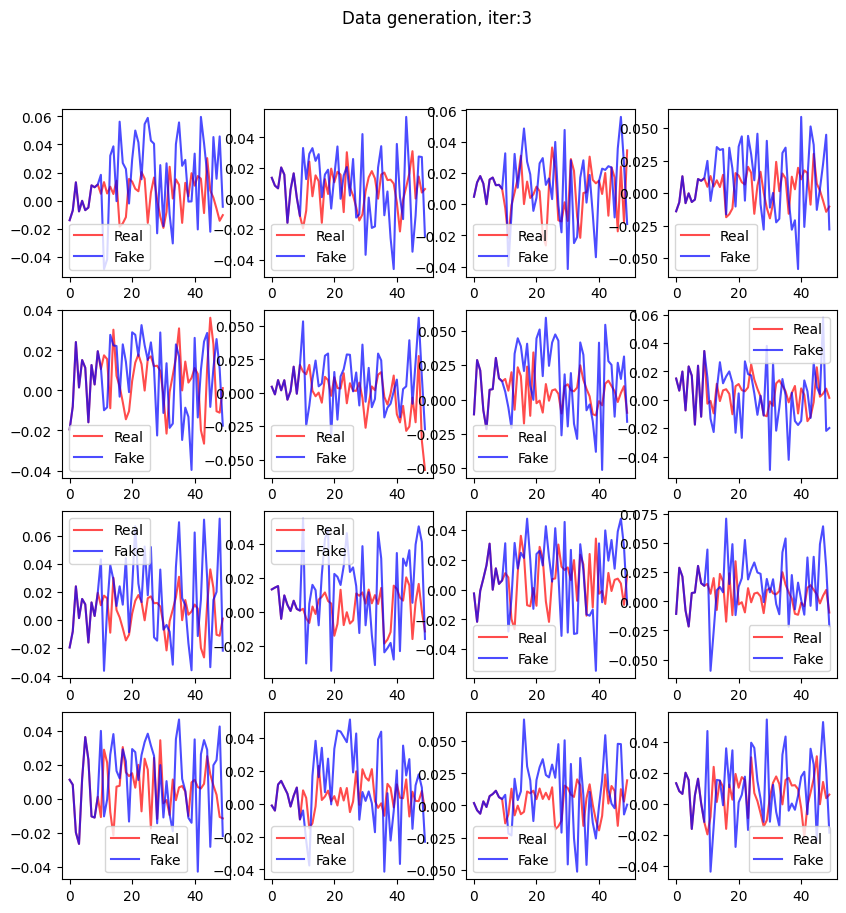

In [27]:
show_examples(train.real_lines, train.fake_lines, size=4)

In [33]:
train.ts_dim

50

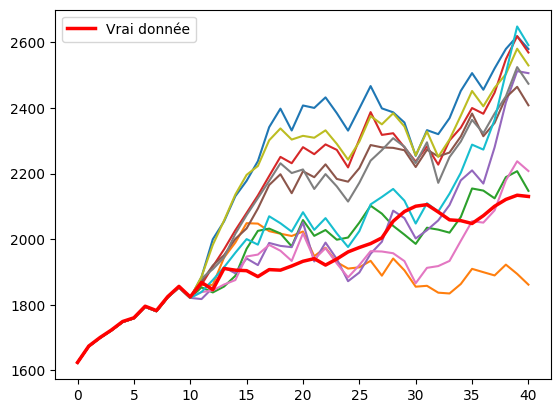

In [35]:
import random
def generate_fake_scenario(input_, true_input, train, amplifier = 1, num = 5):
    for i in range(num):
        conditional = train.conditional
        noise = torch.randn((1, 1, train.latent_dim))*amplifier
        real_samples = torch.from_numpy(input_[:conditional])
        noise[0][0][:conditional] = real_samples[:conditional]
        noise = noise.cuda()
        v = train.G(noise)
        v[0][0][:conditional] = real_samples[:conditional]
        croissance = np.array(v.float().cpu().detach()[0][0])
        fake_line = np.array([true_input[0]] + [true_input[0] * np.prod(1 + croissance[:i+1]) for i in range(40)])
        plt.plot(fake_line)
    plt.plot(true_input[:len(fake_line)], label=f'Vrai donnée', linewidth=2.5, color="red") 
    plt.legend()
    plt.show()
start = random.randint(0,200)

generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 1,num =10)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.095777
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.510422
[t-SNE] KL divergence after 300 iterations: 0.178973


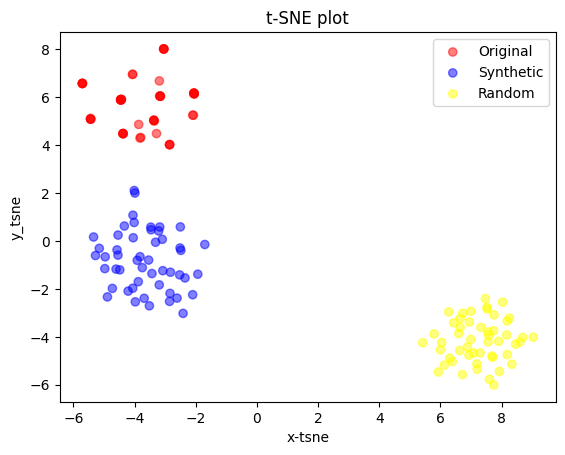

In [36]:
fake , real = train.data.get_samples(G = train.G, latent_dim = train.latent_dim, ts_dim = train.ts_dim, 
                    batch_size=50, conditional= train.conditional, use_cuda=True, data = train.data)
real_array = real.float().cpu().detach().numpy()
fake_array = fake.float().cpu().detach().numpy()
plot_tsne(real_array,fake_array, random=True)